### Import data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix, plot_confusion_matrix,plot_roc_curve,f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
INPUT_PATH = "../../kkbox-churn-prediction-challenge/50_under_sample/"
FILE_NAME = 'train_all.csv'

In [3]:
df = pd.read_csv(INPUT_PATH + FILE_NAME).sort_values('msno')

In [4]:
df.head(1)

,msno,is_churn,city,bd,gender,registered_via,register_days,date_count,num_25_sum,num_25_mean,...,amtperday_std,d_transaction_mean,d_transaction_std,d_expire_date_mean,d_expire_date_std,potential_churn_binary_has,membership_days,listen_member_pct,register_member_sub,member_register_pct
35439,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,0,13,22,male,9,783,462,712,1.541126,...,0.952847,29.692308,4.296689,30.36,0.907377,False,791.0,0.584071,30,1.0


## Model 1: price as continuous

### Pipeline

In [5]:
cat_attribs=['city','gender','registered_via','payment_method_id_most_common','payment_plan_days_most_common',
             #'plan_list_price_most_common',
             #'actual_amount_paid_most_common',
             'is_auto_renew_change_or_not','is_auto_renew_most_common',
             'is_cancel_change_or_not', 'discount_positive_binary_has', 
             'free_binary_has','potential_churn_binary_has']
num_attribs = ['register_days','date_count',
               'num_25_sum','num_50_mean','num_75_sum','num_75_std', # correlation
               'num_985_sum','num_985_std','num_100_sum', 'num_100_std','num_unq_mean','total_secs_sum', # correlation
               'num_25_mean', 'num_25_std','num_50_sum','num_50_std', 
               'num_75_mean', 'num_985_mean', 
               'num_100_mean', 'num_unq_sum', 'num_unq_std',
               'total_secs_mean', 'total_secs_std',
               'payment_method_id_nunique','payment_plan_days_nunique',
               'plan_list_price_nunique','plan_list_price_mean','plan_list_price_std', # correlation
               'plan_list_price_most_common',# this originally is used as categorical
               'actual_amount_paid_most_common', # this originally is used as categorical
               'actual_amount_paid_nunique','actual_amount_paid_mean', 'actual_amount_paid_std',
               'is_auto_renew_pcet_of_zero','is_cancel_mean','discount_amount_find_positive_pct',
               'discount_amount_mean', 'free_mean', 
               'discount_amount_sum',# correlation
               'length_mean', 'length_sum',
               'length_std', # correlation
               'amtperday_mean','amtperday_std', 
               'd_transaction_mean', 'd_transaction_std',
               'd_expire_date_mean', 'd_expire_date_std','membership_days', 
               'listen_member_pct','register_member_sub', # correlation
               'member_register_pct','bd']

In [6]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [7]:
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('onehot',OneHotEncoder(drop="first",categories="auto"))])
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('std_scaler',StandardScaler())
])

In [8]:
full_pipeline = FeatureUnion(transformer_list=[
    ("cat_pipeline",cat_pipeline),
    ("num_pipeline",num_pipeline)
])

In [10]:
X_train = df.iloc[:,2:66]
X_train=X_train.fillna(0)

In [11]:
X_train.head(1)

,city,bd,gender,registered_via,register_days,date_count,num_25_sum,num_25_mean,num_25_std,num_50_sum,...,amtperday_std,d_transaction_mean,d_transaction_std,d_expire_date_mean,d_expire_date_std,potential_churn_binary_has,membership_days,listen_member_pct,register_member_sub,member_register_pct
35439,13,22,male,9,783,462,712,1.541126,2.550453,153,...,0.952847,29.692308,4.296689,30.36,0.907377,False,791.0,0.584071,30,1.0


In [12]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [13]:
y_train = df.iloc[:,1]

### Valiation data

In [14]:
FILE_NAME = 'val_all.csv'
df_val = pd.read_csv(INPUT_PATH + FILE_NAME).sort_values('msno')

X_val = df_val.iloc[:,2:66]
X_val=X_val.fillna(0)

X_val.shape

(21517, 64)

In [15]:
y_val = df_val.iloc[:,1]

In [16]:
X_val_prepared = full_pipeline.transform(X_val)

### Tune Hyper Parameters

In [17]:
def tune_parameters(solver,C_param_list,penalty):
    table = pd.DataFrame(columns = ['C_parameter','f1'])
    table['C_parameter'] = C_param_list
    
    j = 0
    for i in C_param_list:
        lr = LogisticRegression(C = i,max_iter=1500,penalty=penalty,tol=7e-4,random_state=24,solver=solver)
        lr.fit(X_train_prepared,y_train)
        y_val_pred = lr.predict(X_val_prepared)
        table.iloc[j,1] = f1_score(y_val,y_val_pred)
        j+=1
    
    return table

In [18]:
# solver = "lbfgs", penalty = "l2"
lbfgs_l2 = tune_parameters("lbfgs",[0.1,1,10,100,1000],"l2")

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

In [19]:
lbfgs_l2 # C = 1000 is the best, the less regulization, the bettter result

,C_parameter,f1
0,0.1,0.37559
1,1.0,0.431833
2,10.0,0.450493
3,100.0,0.45274
4,1000.0,0.453361


In [20]:
# solver = "saga", penalty = "l2"
saga_l2 = tune_parameters("saga",[0.1,1,10,100],"l2")

In [21]:
saga_l2 # 10 is best

,C_parameter,f1
0,0.1,0.353042
1,1.0,0.364481
2,10.0,0.36623
3,100.0,0.366123


In [22]:
# solver = "saga", penalty = "l1"
saga_l1 = tune_parameters("saga",[0.1,1,10,100],"l1")

In [23]:
saga_l1 # 10 is best

,C_parameter,f1
0,0.1,0.366279
1,1.0,0.366066
2,10.0,0.366337
3,100.0,0.366123


### Test on the test sest

In [24]:
# Test data
FILE_NAME = 'test_all.csv'
df_test = pd.read_csv(INPUT_PATH + FILE_NAME).sort_values('msno')
df_test = df_test[df_test.payment_plan_days_most_common != 66]

X_test = df_test.iloc[:,2:66]
X_test=X_test.fillna(0)

X_test.shape

(22410, 64)

In [25]:
X_test.shape

(22410, 64)

In [26]:
y_test = df_test.iloc[:,1]

X_test_prepared = full_pipeline.transform(X_test)

In [27]:
# best model is with lbfgs_l2 # C = 1000 is the best, the less regulization, the bettter result
lr = LogisticRegression(C = 1000,max_iter=1500,penalty='l2',tol=7e-4,random_state=24,solver='lbfgs')
lr.fit(X_train_prepared,y_train)
y_test_pred = lr.predict(X_test_prepared)

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_test_pred,average='binary')

(0.3044030482641829, 0.9021329987452948, 0.45520734409623304, None)

### Feature Importance

In [29]:
sum = 0
cat_count = dict.fromkeys(cat_attribs)
for i in cat_attribs:
    cat_count[i] = X_train[i].nunique()       
    sum = X_train[i].nunique()+sum

In [30]:
sum-len(cat_attribs)

90

In [31]:
# total columns
sum-len(cat_attribs)+len(num_attribs)

143

In [101]:
coef=pd.DataFrame(lr.coef_.reshape(-1,1))

In [102]:
coef['feature']=""

In [103]:
coef.columns=['value','feature']

In [104]:
coef["abs"] = np.where(coef['value']>=0,coef['value'],abs(coef['value']))

In [106]:
coef.sort_values('value').iloc[0:10,:]

,value,feature,abs
140,-22.480862,,22.480862
138,-6.479231,,6.479231
33,-4.444132,,4.444132
122,-3.882480,,3.882480
91,-1.803637,,1.803637
71,-1.291732,,1.291732
129,-1.266571,,1.266571
84,-1.096363,,1.096363
126,-1.037151,,1.037151
66,-0.866368,,0.866368


In [35]:
cat_count

{'city': 21,
 'discount_positive_binary_has': 2,
 'free_binary_has': 2,
 'gender': 3,
 'is_auto_renew_change_or_not': 2,
 'is_auto_renew_most_common': 2,
 'is_cancel_change_or_not': 2,
 'payment_method_id_most_common': 36,
 'payment_plan_days_most_common': 25,
 'potential_churn_binary_has': 2,
 'registered_via': 4}

In [36]:
coef.iloc[140,1]=num_attribs[140-90]
coef.iloc[138,1]=num_attribs[138-90]
coef.iloc[33,1]='payment_method_id_15'
coef.iloc[122,1]=num_attribs[122-90]
coef.iloc[91,1]=num_attribs[91-90]
coef.iloc[71,1]='payment_plan_days_90'
coef.iloc[129,1]=num_attribs[129-90]
coef.iloc[84,1]='is_auto_renew_change_or_not'
coef.iloc[126,1]=num_attribs[126-90]
coef.iloc[66,1]='payment_plan_days_31'

In [37]:
coef_10=coef.sort_values(0).iloc[0:10,:]

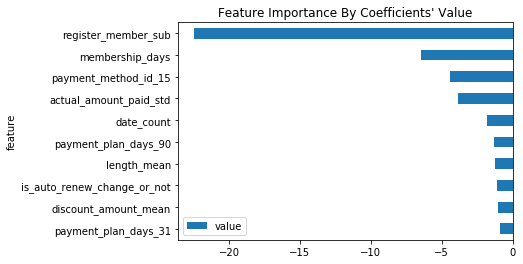

In [40]:
coef_10.sort_values('value',ascending=False).plot.barh(x='feature', y='value')
plt.title("Feature Importance By Coefficients' Value")
plt.show()

### EDA

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


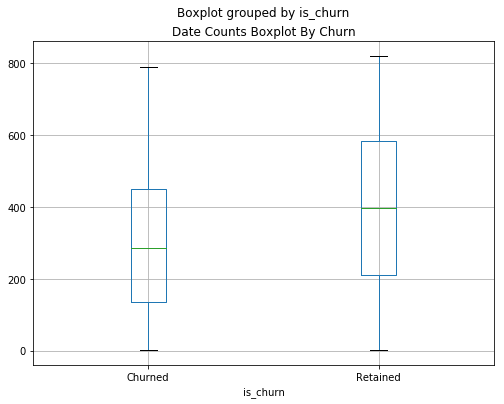

In [107]:
#df.is_churn = np.where(df.is_churn==0,"Retained","Churned")

df.boxplot(column='date_count',by='is_churn',figsize=(8,6))
plt.title('Date Counts Boxplot By Churn')
plt.show()

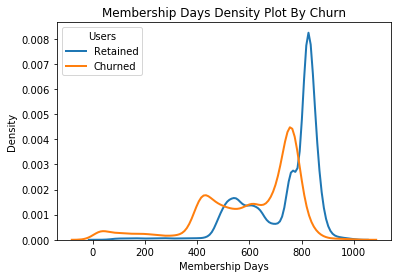

In [82]:
df_new = df[df.membership_days<1000]
import seaborn as sns
Type = ['Retained', 'Churned']

for i in Type:
    # Subset to the airline
    subset = df_new[df_new['is_churn'] == i]
    
    # Draw the density plot
    sns.distplot(subset['membership_days'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = i)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Users')
plt.title('Membership Days Density Plot By Churn')
plt.xlabel('Membership Days')
plt.ylabel('Density')
plt.show()

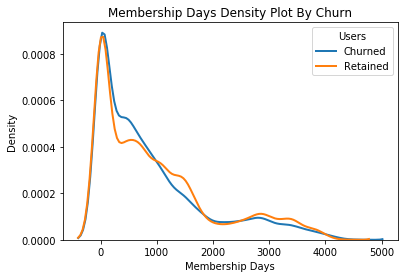

In [97]:
#df_new = df[df.date_count>200]
import seaborn as sns
Type = ['Churned','Retained']

for i in Type:
    subset = df[df['is_churn'] == i]
    
    sns.distplot(subset['register_member_sub'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = i)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Users')
plt.title('Membership Days Density Plot By Churn')
plt.xlabel('Membership Days')
plt.ylabel('Density')
plt.show()